![](https://api.brandy.run/core/core-logo-wide)

# Supervised Learning: KNN

- K Nearest Neighbors

[(5, 1.0, array([5, 4, 1])), (6, 1.4142135623730951, array([5, 3, 1])), (4, 2.8284271247461903, array([6, 6, 0]))]
[1, 1, 0] 1


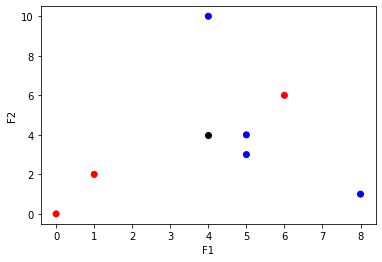

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import Counter

X = np.array([
    [0,0,0],
    [1,2,0],
    [4,10,1],
    [8,1,1],
    [6,6,0],
    [5,4,1],
    [5,3,1]
])

x = X[:,0]
y = X[:,1]
cl = X[:,2]
color = np.where(cl == 0, "red", "blue")
          

plt.scatter(x,y, c = color)
plt.xlabel("F1")
plt.ylabel("F2")

m = [4,4]
plt.scatter(m[0],m[1],color="black")

# https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa
def euclidean(x,y):
    return math.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)

distances = [(i,euclidean(e,m),e) for i,e in enumerate(X)]


#K primeros
sorted_distances = sorted(distances, key=lambda e: e[1])
#print(sorted_distances)

K=3
K_sorted_distances = sorted_distances[:K]

print(K_sorted_distances)

votes = [e[2][2] for e in K_sorted_distances]

occurence_count = Counter(votes)
result_class = occurence_count.most_common(1)[0][0]

print(votes, result_class)

In [2]:
class KNN:
    def __init__(self, k):
        self.k = k
    def fit(self, X, y):
        self.X = X
        self.y = y
        return self
    def predict(self,X):
        return X.apply(self._predict, axis=1)
    def _predict(self, x, k=None):
        if k == None:
            k = self.k
        dist = [(i, self.euclidean_dist(a,x)) for i, a in self.X.iterrows()]
        dist = sorted(dist, key=lambda x: x[1])
        k_neighbors = [i[0] for i in dist[:k]]
        pred = self.y.loc[k_neighbors].mode()
        if pred.shape[0] > 1:
            return self._predict(x,k=k-1)
        return pred
    def euclidean_dist(self,a,b):
        return (sum(a-b)**2)**.5

## Porqué KNN?

- Permite distribuir la computación de las distancias entre varios ordenadores (computación distribuida)

EJ: Tenemos un dataset con 1M de datapoints y un cluster de 10 ordenadores. Cada ordenador calcula solo 100.000 distancias

- Es un algoritmo que no tiene entrenamiento. Porque cada vez que queremos calcular la predición de un nuevo sample (hacer inferencia). Hay que recalcular las distancias de nuevo


In [3]:
knn = KNN(3)

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X,y = fetch_openml("mnist_784", return_X_y=True)
sevens = y == "7"

X_train, X_test, y_train, y_test = train_test_split(X,sevens)


In [5]:
knn.fit(X_train,y_train)

## KNN



In [6]:
knn.predict(X.iloc[:5])

,0
0,False
1,False
2,True
3,False
4,False


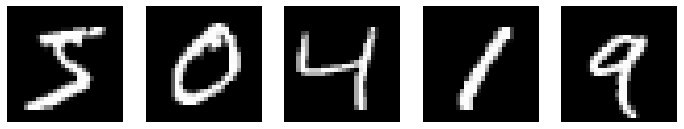

In [7]:
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X.iloc[i].values.reshape((28,28)), cmap="gray")
    plt.axis("off")

In [8]:
# Using a smaller sample of data:

X_samp, y_samp = X[:2000], y[:2000]
sevens_samp = y_samp == "7"
X_train, X_test, sevens_train, sevens_test =  train_test_split(X_samp, sevens_samp, random_state=42)

In [9]:
y_samp.value_counts()

7    224
1    220
4    214
9    210
6    200
2    198
0    191
3    191
5    180
8    172
Name: class, dtype: int64

In [10]:
knn = KNN(3)
knn.fit(X_train,sevens_train)

In [11]:
y_pred = knn.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

In [14]:
accuracy_score(sevens_test,y_pred)

0.858

In [15]:
precision_score(sevens_test,y_pred)

0.13793103448275862

In [16]:
recall_score(sevens_test,y_pred)

0.08

In [17]:
f1_score(sevens_test,y_pred)

0.10126582278481013

No obtuvimos un resultado muy bueno con ese modelo... 😕

Pero, lo que tendríamos que considerar es que la distancia euclidea no es la unica que puede ser aplicada al KNN. 

Veamos la diferencia usando otra manera de calcular las distancias:

In [18]:
class KNN:
    def __init__(self, k, distance=None):
        self.k = k
        if distance==None:
            distance=self.euclidean_dist
        self.distance = distance
    def fit(self, X, y):
        self.X = X
        self.y = y
        return self
    def predict(self,X):
        return X.apply(self._predict, axis=1)
    def _predict(self, x, k=None):
        if k == None:
            k = self.k
        dist = [(i, self.distance(a,x)) for i, a in self.X.iterrows()]
        dist = sorted(dist, key=lambda x: x[1])
        k_neighbors = [i[0] for i in dist[:k]]
        pred = self.y.loc[k_neighbors].mode()
        if pred.shape[0] > 1:
            return self._predict(x,k=k-1)
        return pred
    def euclidean_dist(self,a,b):
        return (sum(a-b)**2)**.5

In [19]:
from scipy.spatial.distance import minkowski
knn = KNN(3, distance=minkowski)
knn.fit(X_train,sevens_train)

In [20]:
y_pred = knn.predict(X_test)

In [21]:
accuracy_score(sevens_test,y_pred)

0.978

In [22]:
precision_score(sevens_test,y_pred)

0.9148936170212766

In [23]:
recall_score(sevens_test,y_pred)

0.86

In [24]:
f1_score(sevens_test,y_pred)

0.8865979381443299

Vaya cambio! 😎

## Choosing K

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
k = range(3, 101)

In [27]:
errors = []
for k_neigh in k:
    knn = KNeighborsClassifier(k_neigh)
    knn.fit(X_train, sevens_train)
    y_pred = knn.predict(X_test)
    errors.append((y_pred != sevens_test).sum()/y_pred.shape[0])

In [28]:
errors

[0.022,
 0.022,
 0.024,
 0.02,
 0.02,
 0.024,
 0.024,
 0.026,
 0.024,
 0.024,
 0.024,
 0.026,
 0.026,
 0.026,
 0.026,
 0.028,
 0.028,
 0.03,
 0.028,
 0.028,
 0.026,
 0.028,
 0.028,
 0.03,
 0.028,
 0.028,
 0.028,
 0.028,
 0.028,
 0.028,
 0.028,
 0.03,
 0.03,
 0.03,
 0.03,
 0.032,
 0.032,
 0.034,
 0.034,
 0.034,
 0.034,
 0.034,
 0.034,
 0.034,
 0.034,
 0.034,
 0.034,
 0.034,
 0.034,
 0.036,
 0.034,
 0.036,
 0.034,
 0.034,
 0.036,
 0.038,
 0.038,
 0.036,
 0.036,
 0.036,
 0.036,
 0.036,
 0.036,
 0.034,
 0.036,
 0.038,
 0.038,
 0.038,
 0.038,
 0.038,
 0.038,
 0.038,
 0.038,
 0.038,
 0.038,
 0.038,
 0.038,
 0.038,
 0.038,
 0.038,
 0.038,
 0.038,
 0.038,
 0.04,
 0.038,
 0.04,
 0.04,
 0.042,
 0.04,
 0.042,
 0.04,
 0.044,
 0.044,
 0.044,
 0.044,
 0.046,
 0.046,
 0.046]

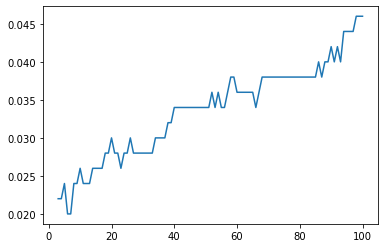

In [29]:
plt.plot(k,errors)